In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import *
import seaborn as sns
import h5py
from vizman import viz


/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
viz.set_visual_style()
viz_sizes = viz.load_data_from_json("sizes.json")
viz_colors = viz.load_data_from_json("colors.json")
viz_cmaps = viz.give_colormaps()
sns_kwargs = {"cmap": viz_cmaps["bw_lr"],
              "xticklabels":False,
              "yticklabels":False,
              "rasterized":True}

In [4]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/human/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))
all_connectivities = scipy.io.loadmat(
    "datasets/human/Individual_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)['connMatrices']['SC'][res_parcellation].astype(bool)

In [5]:
all_connectivities.shape

(114, 114, 70)

In [6]:
empirical_densities = np.array([check_density(all_connectivities[:,:,i]) for i in range(all_connectivities.shape[2])])

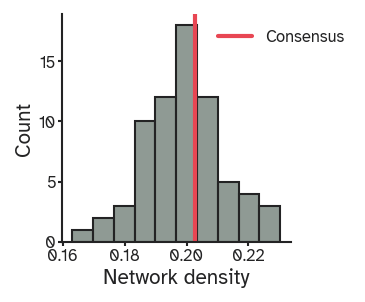

In [8]:
plt.figure(figsize=viz.cm_to_inch((5,5)), dpi=150)
sns.histplot(empirical_densities)
plt.axvline(check_density(connectivity),
            lw=2,color=viz_colors["warms"]["LECKER_RED"],label="Consensus")
plt.xlabel("Network density")
plt.legend(bbox_to_anchor=(1.3,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_allconns_density_histplot.pdf",dpi=600,bbox_inches='tight');

Text(0.5, 1.0, 'Propagation distance')

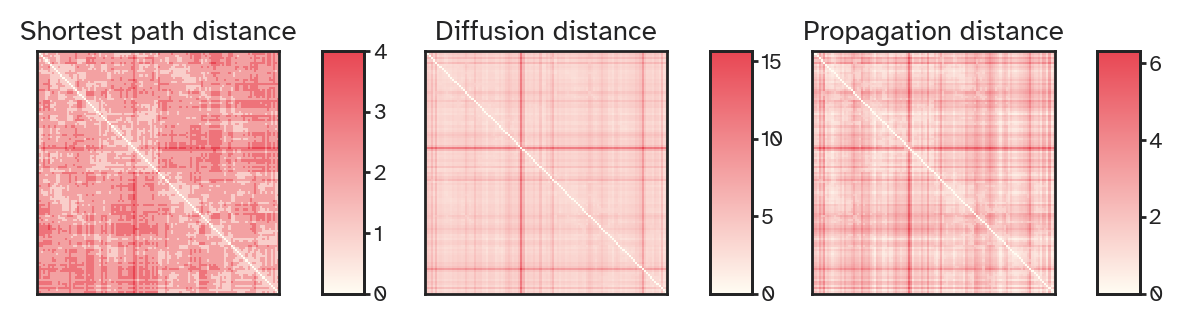

In [9]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"]], 
                               figsize=(viz.cm_to_inch((18,4))),
                               dpi=200)
viz.plot_matrix(gen.shortest_path_distance(connectivity, coordinates),
                cbar=True,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(gen.resistance_distance(connectivity, coordinates), 
                cbar=True, sns_kwargs=sns_kwargs, axis=axes["B"])
viz.plot_matrix(gen.propagation_distance(connectivity), 
                cbar=True, 
                sns_kwargs=sns_kwargs, axis=axes["C"])
axes["A"].set_title("Shortest path distance")
axes["B"].set_title("Diffusion distance")
axes["C"].set_title("Propagation distance")

#plt.savefig("figures/res1_rd_vs_sp_heatmaps.pdf",dpi=600,bbox_inches='tight');

In [10]:
SIMULATE = False
if SIMULATE:
    n_iterations = 10_000
    n_nodes = connectivity.shape[0]
    beta = np.full(n_iterations, 1)
    noise = np.zeros(n_iterations)
    penalty = np.zeros(n_iterations)
    batch_size = np.full(n_iterations, 16)

    start = 1
    stop = 10
    numsteps = stop - start
    params = np.linspace(start, stop, numsteps)
    scores = np.zeros(len(params))
    histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
    densities = np.zeros(len(params))
    for ind, val in enumerate(params):
        alpha = np.full(n_iterations, val)
        histories[...,ind] = gen.simulate_network_evolution(
            coordinates=coordinates,
            n_iterations=n_iterations,
            alpha=alpha,
            beta=np.full(n_iterations, 1),
            noise=noise,
            distance_fn=gen.propagation_distance,
            connectivity_penalty=penalty,
            n_jobs=-1,
            random_seed=11,
            batch_size=batch_size,
        )
        scores[ind] = density_distance(connectivity, histories[:,:,-1,ind])
        densities[ind] = check_density(histories[:,:,-1,ind])
        print(f"Parameter {ind+1}/{len(params)} error: {scores[ind]:.2f}")
    np.save("simulations/pd_alpha08_10k_res1_scores.npy",scores)
    np.save("simulations/pd_alpha08_10k_res1_matrices.npy",histories)
    np.save("simulations/pd_alpha08_10k_res1_densities.npy",densities)

In [5]:
pd_scores = np.load("simulations/pd_alpha08_10k_res1_scores.npy")
pd_matrices = np.load("simulations/pd_alpha08_10k_res1_matrices.npy")
pd_densities = np.load("simulations/pd_alpha08_10k_res1_densities.npy")

rd_densities = np.load("simulations/rd_10k_res1_densities.npy")
rd_scores = np.load("simulations/rd_10k_res1_scores.npy")

sp_densities = np.load("simulations/sp_30k_res1_densities.npy")
sp_scores = np.load("simulations/sp_30k_res1_scores.npy")

td_densities = np.load("simulations/td_3k_res1_densities.npy")
td_scores = np.load("simulations/td_3k_res1_scores.npy")
td_matrices = np.load("simulations/td_3k_res1_matrices.npy")

In [6]:
best_pd = pd_matrices[:,:,:, np.argmin(pd_scores)]
best_td = td_matrices[:,:,:, np.argmin(td_scores)]

In [7]:
with h5py.File("simulations/rd_10k_res1_matrices.h5", "r") as f:
    best_rd = f["data"][:,:,:,np.argmin(rd_scores)]
best_rd.shape

(114, 114, 10000)

In [8]:
with h5py.File("simulations/sp_30k_res1_matrices.h5", "r") as f:
    best_sp = f["data"][:,:,:,np.argmin(sp_scores)]
best_sp.shape

(114, 114, 30000)

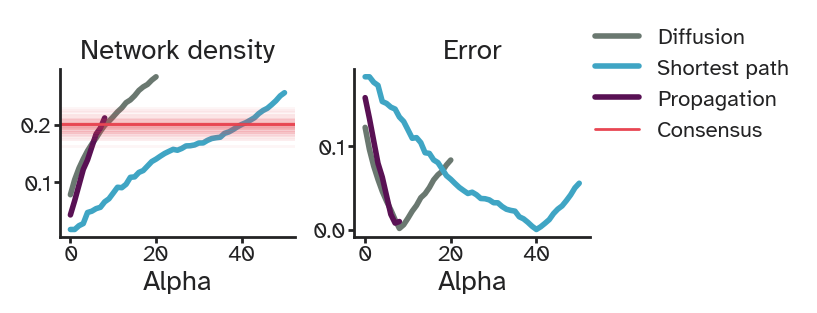

In [21]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
axes["A"].plot(rd_densities,lw=2,label="Diffusion")
axes["A"].plot(sp_densities,lw=2,color=viz_colors["colds"]["LAKE_BLUE"],label="Shortest path")
axes["A"].plot(pd_densities,lw=2,color=viz_colors["purples"]["PURPLER"],label="Propagation")
#axes["A"].plot(td_densities,lw=2,color=viz_colors["greens"]["SLOW_GREEN"],label="Topological")

axes["A"].axhline(check_density(connectivity),color=viz_colors["warms"]["LECKER_RED"],label="Consensus")

for subject in range(all_connectivities.shape[2]):
    axes["A"].axhline(densities[subject],color=viz_colors["warms"]["LECKER_RED"],alpha=0.05)


axes["B"].plot(rd_scores,lw=2)
axes["B"].plot(pd_scores,lw=2,color=viz_colors["purples"]["PURPLER"])
axes["B"].plot(sp_scores,lw=2,color=viz_colors["colds"]["LAKE_BLUE"])
#axes["B"].plot(td_scores,lw=2,color=viz_colors["greens"]["SLOW_GREEN"])

axes["A"].set_title("Network density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.legend(bbox_to_anchor=(1.3,1),frameon=False)
fig.tight_layout(w_pad=0.1)
sns.despine()
#plt.savefig("figures/res1_densities_errors.pdf",dpi=600,bbox_inches='tight');

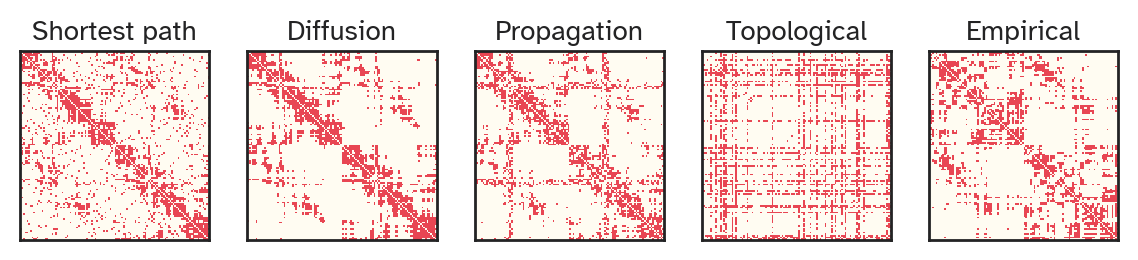

In [205]:
fig, axes = plt.subplot_mosaic([["A", "B", "C", "X","D"]], 
                               figsize=(viz.cm_to_inch((18,4))),
                               dpi=200)
viz.plot_matrix(best_sp[:,:,-1],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(best_rd[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["B"])
viz.plot_matrix(best_pd[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["C"])
viz.plot_matrix(best_td[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["X"])
viz.plot_matrix(connectivity, 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["D"])
axes["A"].set_title("Shortest path")
axes["B"].set_title("Diffusion")
axes["C"].set_title("Propagation")
axes["X"].set_title("Topological")
axes["D"].set_title("Empirical")
#plt.savefig("figures/res1_generated_adjmats.pdf",dpi=600,bbox_inches='tight');

In [9]:
sp_samples = best_sp[:,:,-70:].copy()
rd_samples = best_rd[:,:,-70:].copy()
pd_samples = best_pd[:,:,-70:].copy()
td_samples = best_td[:,:,-70:].copy()

In [103]:
correlation_matrix = np.zeros((5,5,sp_samples.shape[2]))

# Calculate correlations for each timepoint
for t in range(sp_samples.shape[2]):
    # Get networks at timepoint t
    networks = {
        'SP': sp_samples[:,:,t],
        'RD': rd_samples[:,:,t],
        'PD': pd_samples[:,:,t],
        'TD': td_samples[:,:,t], 
        'Emp': all_connectivities[:,:,t]
    }
    
    # Calculate correlations between all pairs
    for i, name1 in enumerate(networks):
        for j, name2 in enumerate(networks):
            correlation_matrix[i,j,t] = evaluate_adjacency(networks[name1], networks[name2])[1]

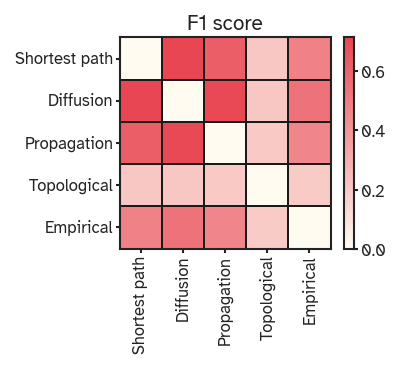

In [107]:
# Plot average correlation matrix
plt.figure(figsize=(viz.cm_to_inch((7,7))), dpi=150)
labels = ['Shortest path', 'Diffusion', 'Propagation', 'Topological', 'Empirical']
mean_corr = np.mean(correlation_matrix, axis=2)
mean_corr[np.diag_indices(5)] = 0
sns.heatmap(mean_corr, 
            xticklabels=labels,
            yticklabels=labels,
            cmap=viz_cmaps["db_bw_lr"],
            center=0,
            square=True,
            linewidths=0.01,
            linecolor='k',
            cbar_kws={"shrink":0.72})

plt.title("F1 score")
sns.despine(left=False, bottom=False, right=False, top=False)
plt.tight_layout()
#plt.savefig("figures/res1_F1_nettypes.pdf",dpi=600,bbox_inches='tight');

In [360]:
from utils import brain_plotter

In [427]:
rd_coupling = calculate_endpoint_similarity(sp_samples[:,:,-1], connectivity)

In [397]:
sagittal = (0, 180)
axial = (90, 180) # these are actually wrong but they do the job so I'm not changing them!
coronal = (0, 90)
bottom = (-90, 0)
size = 400
scatter_kw = dict(alpha=1, linewidths=2, edgecolors=viz_colors["neutrals"]["HALF_BLACK"])


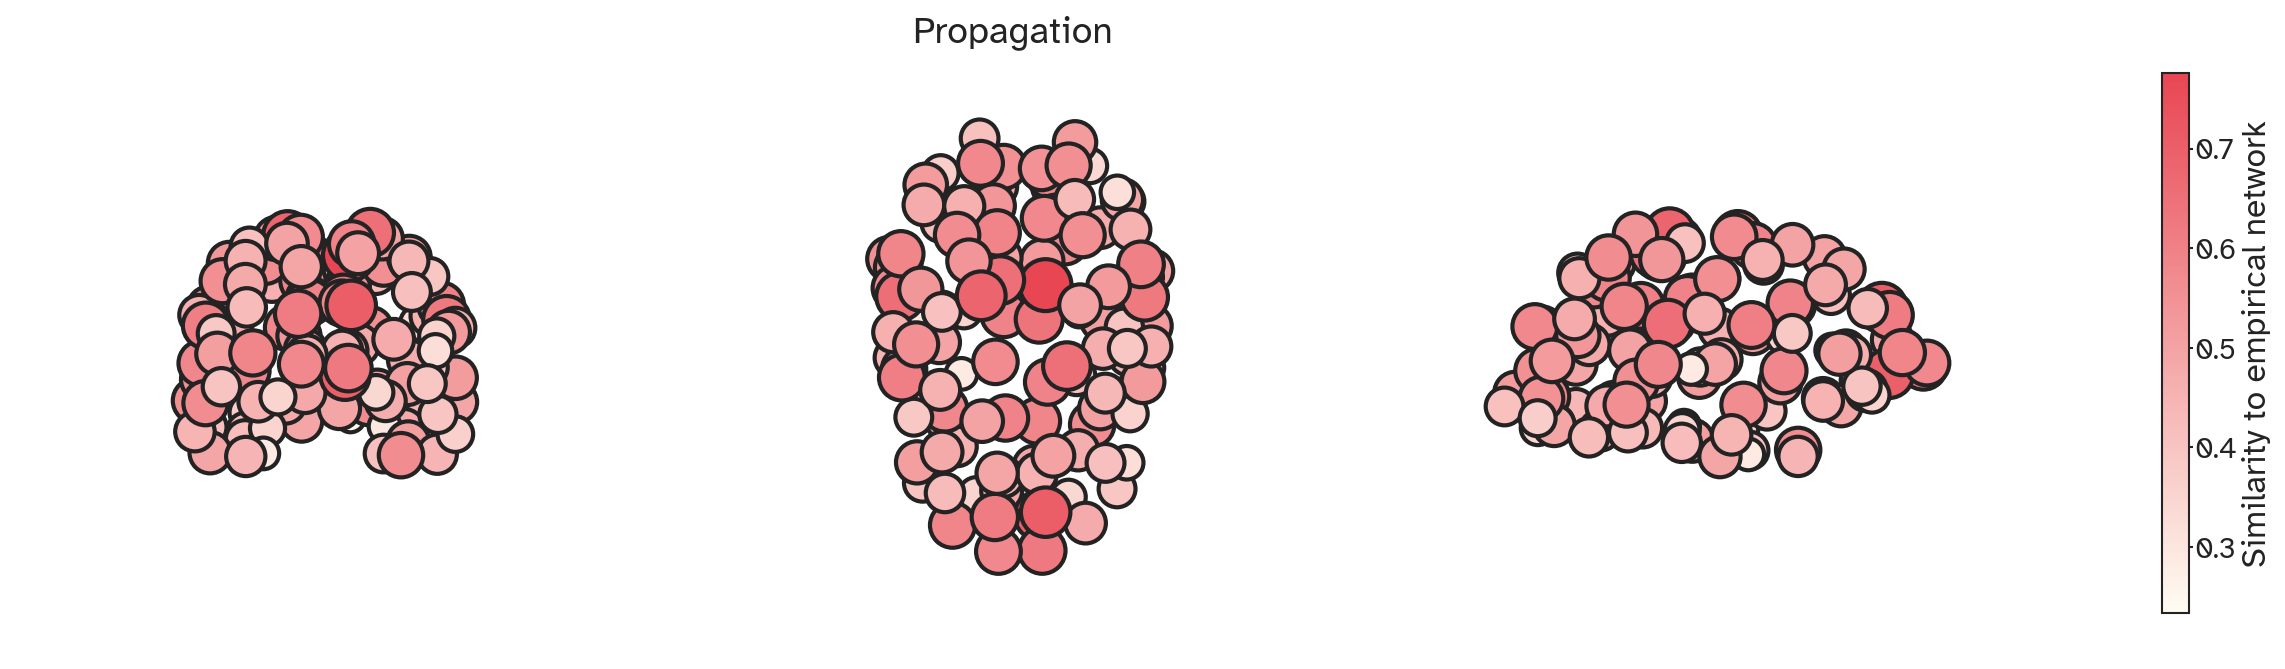

In [433]:
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "cbar"]], 
    figsize=viz_sizes["half_page"], 
    subplot_kw=dict(projection="3d"),
    gridspec_kw={'width_ratios': [1, 1, 1, 0.01]},  # Make space for colorbar
    dpi=150
)

# Remove 3D projection from colorbar axis
axes["cbar"].remove()
axes["cbar"] = fig.add_axes([0.92, 0.35, 0.01, 0.3])  # [left, bottom, width, height]

brain_plotter(
    rd_coupling,
    coordinates,
    axes["A"],
    view=sagittal,
    size=size*(rd_coupling*2),
    cmap=viz_cmaps["bw_lr"],
    scatter_kwargs=scatter_kw,
)
brain_plotter(
    rd_coupling,
    coordinates,
    axes["B"],
    view=axial,
    size=size*(rd_coupling*2),
    cmap=viz_cmaps["bw_lr"],
    scatter_kwargs=scatter_kw,
)
brain_plotter(
    rd_coupling,
    coordinates,
    axes["C"],
    view=coronal,
    size=size*(rd_coupling*2),
    cmap=viz_cmaps["bw_lr"],
    scatter_kwargs=scatter_kw,
)

# Add colorbar with larger text
norm = plt.Normalize(vmin=rd_coupling.min(), vmax=rd_coupling.max())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=viz_cmaps["bw_lr"]), 
                   cax=axes["cbar"])
cbar.set_label("Similarity to empirical network", size=16)  # Increase label size
cbar.ax.tick_params(labelsize=14)  # Increase tick label size
axes["B"].set_title("Propagation", fontsize=18)
plt.savefig(f"figures/res1_point_brain_pd_similarity.pdf",dpi=600,bbox_inches='tight');

In [ ]:
# pd_measures = compute_graph_metrics_parallel(pd_samples,
#                                              connectivity,
#                                              euclidean_dis,
#                                              coordinates)
# pd_measures.to_csv("results/pd_measures.csv",index=False)

# sp_measures = compute_graph_metrics_parallel(sp_samples,
#                                             connectivity,
#                                             euclidean_dis,
#                                             coordinates)
# sp_measures.to_csv("results/sp_measures.csv",index=False)

# rd_measures = compute_graph_metrics_parallel(rd_samples,
#                                             connectivity,
#                                             euclidean_dis,
#                                             coordinates)
# rd_measures.to_csv("results/rd_measures.csv",index=False)

# td_measures = compute_graph_metrics_parallel(td_samples,
#                                             connectivity,
#                                             euclidean_dis,
#                                             coordinates)
# td_measures.to_csv("results/td_measures.csv",index=False)

# empirical_measures = compute_graph_metrics_parallel(all_connectivities,
#                                                     connectivity,
#                                                     euclidean_dis,
#                                                     coordinates)
# empirical_measures.to_csv("results/empirical_measures.csv",index=False)







































































































































































































100%|██████████| 70/70 [02:16<00:00,  1.94s/it]


In [112]:
from bct import randmio_und, latmio_und

In [116]:
# randomized_networks = np.zeros_like(all_connectivities)
# latticized_networks = np.zeros_like(all_connectivities)

# for subject in tqdm(range(all_connectivities.shape[2])):
#     # randmio_und returns a tuple (randomized_matrix, num_swaps)
#     # we only want the randomized matrix
#     randomized_networks[:,:,subject] = randmio_und(all_connectivities[:,:,subject],
#                                                    itr=100, seed=subject)[0]
#     # latmio_und returns a tuple (latticized_matrix, num_swaps)
#     # we only want the latticized matrix
#     latticized_networks[:,:,subject] = latmio_und(all_connectivities[:,:,subject],
#                                                   itr=100, seed=subject)[0]

# np.save("datasets/human/randomized_networks.npy",randomized_networks)
# np.save("datasets/human/latticized_networks.npy",latticized_networks)

100%|██████████| 70/70 [12:09<00:00, 10.43s/it]


In [181]:
# randomized_networks = np.load("datasets/human/randomized_networks.npy")
# latticized_networks = np.load("datasets/human/latticized_networks.npy")

In [ ]:
# randomized_measures = compute_graph_metrics_parallel(randomized_networks,
#                                                      connectivity,
#                                                      euclidean_dis,
#                                                      coordinates)
# latticized_measures = compute_graph_metrics_parallel(latticized_networks,
#                                                      connectivity,
#                                                      euclidean_dis,
#                                                      coordinates)
# randomized_measures.to_csv("results/randomized_measures.csv",index=False)
# latticized_measures.to_csv("results/latticized_measures.csv",index=False)





























































































































































































































































100%|██████████| 70/70 [01:55<00:00,  1.64s/it]














Computing graph metrics:   0%|          | 0/70 [02:13<?, ?it/s]



























































































































































































































































































































100%|██████████| 70/70 [01:58<00:00,  1.69s/it]


In [183]:
# measure_labels = ["diffusion distance",
#                     "shortest path distance",
#                     "propagation distance",
#                     "topological distance",
#                     "density",
#                     "wiring cost",
#                     "average clustering",
#                     "degree assortativity",
#                     "small-worldness",
#                     "endpoint similarity",
#                     "accuracy",
#                     "F1 score"]

# consensus_measures = np.zeros(len(measure_labels))
# consensus_measures[0] = resistance_distance(connectivity,coordinates).mean()
# consensus_measures[1] = shortest_path_distance(connectivity,coordinates).mean()
# consensus_measures[2] = propagation_distance(connectivity,coordinates).mean()
# consensus_measures[3] = topological_distance(connectivity,coordinates).mean()

# consensus_measures[4] = check_density(connectivity)
# consensus_measures[5] = calculate_wiring_cost(connectivity,euclidean_dis)
# G = nx.from_numpy_array(connectivity)
# consensus_measures[6] = nx.average_clustering(G)
# consensus_measures[7] = nx.degree_assortativity_coefficient(G)
# consensus_measures[8] = compute_omega(connectivity)
# consensus_measures = pd.DataFrame([consensus_measures], columns=measure_labels)
# consensus_measures.to_csv("results/consensus_measures.csv",index=False)

Computing graph metrics:   0%|          | 0/70 [02:57<?, ?it/s]


In [ ]:
consensus_measures = pd.read_csv("results/consensus_measures.csv")

In [184]:
# import pandas as pd

# # First, add a 'model' column to each dataframe
# sp_measures['model'] = 'Shortest path'
# rd_measures['model'] = 'Diffusion'
# pd_measures['model'] = 'Propagation'
# td_measures['model'] = 'Topological'
# empirical_measures['model'] = 'Empirical'
# latticized_measures['model'] = 'Latticized'
# randomized_measures['model'] = 'Randomized'
# # Concatenate all dataframes vertically
# all_measures = pd.concat([
#     sp_measures,
#     rd_measures,
#     pd_measures,
#     td_measures,
#     empirical_measures,
#     latticized_measures,
#     randomized_measures,
# ], axis=0).reset_index(drop=True)

# # Add a unique identifier for each row
# all_measures['sample_id'] = all_measures.groupby('model').cumcount()

# all_measures.replace([np.inf, -np.inf], np.nan, inplace=True)
# all_measures.to_csv("results/all_measures.csv",index=False)

In [185]:
all_measures = pd.read_csv("results/all_measures.csv")

In [187]:
colors = [viz_colors["colds"]["LAKE_BLUE"],
          viz_colors["neutrals"]["OLIVE_GRAY"],
          viz_colors["purples"]["PURPLER"],
          viz_colors["warms"]["ORANGE"],
          viz_colors["warms"]["LECKER_RED"],
          viz_colors["neutrals"]["GRAY"],
          viz_colors["neutrals"]["GRAY"]]

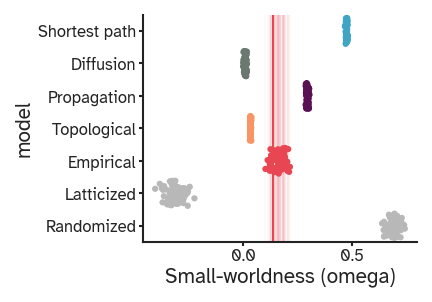

In [200]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=150)
measure = "small-worldness"
sns.stripplot(data=all_measures, 
              y="model",
              x=measure,
              hue="model",
              size=3,
              jitter=0.4,
              palette=colors)

empirical_values = all_measures[all_measures['model'] == 'Empirical'][measure]
for value in empirical_values:
    plt.axvline(value, color=viz_colors["warms"]["LECKER_RED"], alpha=0.03)
plt.axvline(consensus_measures[measure].values[0], color=viz_colors["warms"]["LECKER_RED"], lw=1)
plt.xlabel(measure.capitalize()+" (omega)")

#plt.xlim(-0.03,0.32)
sns.despine()
plt.savefig(f"figures/res1_allconns_{measure}_stripplot.pdf",dpi=600,bbox_inches='tight');

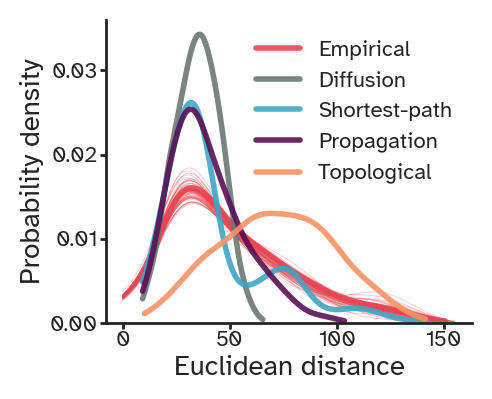

In [257]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=200)
cumu = False
sns.kdeplot(euclidean_dis[connectivity],
            label='Empirical',
            lw=2,
            alpha=0.9,
            color=viz_colors["warms"]["LECKER_RED"],
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)
for subject in range(all_connectivities.shape[2]):
    sns.kdeplot(euclidean_dis[all_connectivities[:,:,subject]],
                lw=0.3,
                alpha=0.3,
                color=viz_colors["warms"]["LECKER_RED"],
                fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)

sns.kdeplot(euclidean_dis[rd_samples[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Diffusion',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)


sns.kdeplot(euclidean_dis[best_sp[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Shortest-path',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)
sns.kdeplot(euclidean_dis[best_pd[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Propagation',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu,
            color = viz_colors["purples"]["PURPLER"],)
sns.kdeplot(euclidean_dis[best_td[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Topological',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu,
            color = viz_colors["warms"]["ORANGE"],)

plt.xlabel('Euclidean distance')
plt.ylabel('Probability density')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_ed_kdeplot.pdf",dpi=600,bbox_inches='tight');

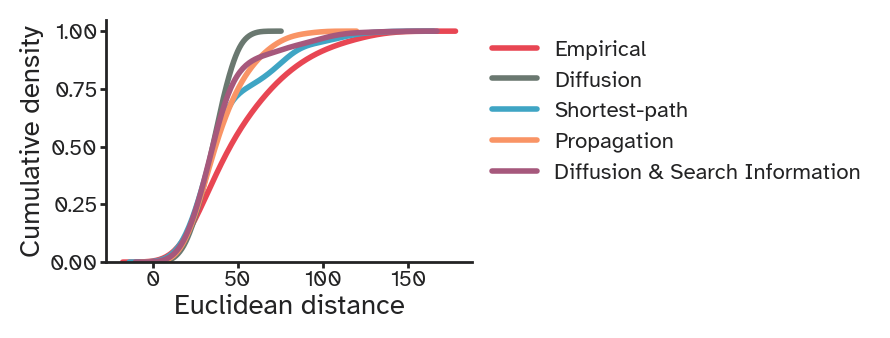

In [372]:
plt.figure(figsize=(viz.cm_to_inch((6,4))), dpi=200)
sns.kdeplot(euclidean_dis[connectivity],
            label='Empirical',
            color=viz_colors["warms"]["LECKER_RED"],lw=2,
            bw_adjust=1.5,cumulative=True)

sns.kdeplot(euclidean_dis[best_rd[:,:,-1].astype(bool)],
            label='Diffusion',lw=2,
            bw_adjust=1.5,cumulative=True)
sns.kdeplot(euclidean_dis[best_sp[:,:,-1].astype(bool)],
            label='Shortest-path',lw=2,
            bw_adjust=1.5,cumulative=True)
sns.kdeplot(euclidean_dis[best_pd[:,:,-1].astype(bool)],
            label='Propagation',lw=2,
            bw_adjust=1.5,cumulative=True)

sns.kdeplot(euclidean_dis[histories[:,:,-1].astype(bool)],
            label='Diffusion & Search Information',lw=2,
            bw_adjust=1.5,cumulative=True)

plt.xlabel('Euclidean distance')
plt.ylabel('Cumulative density')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
sns.despine()
plt.savefig("figures/res1_ed_cummulative_kdeplot_sidd.pdf",dpi=600,bbox_inches='tight');

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [93]:
indices = np.arange(np.shape(all_connectivities)[2])
#indices = np.arange(12)
train_idx, test_idx = train_test_split(indices, train_size=50, random_state=11)
X_train_list = []
y_train_list = []

for idx in train_idx:
    X = np.column_stack([
        sp_samples[:, :, idx].flatten(),
        rd_samples[:, :, idx].flatten(),
        pd_samples[:, :, idx].flatten(),
        td_samples[:, :, idx].flatten(),
    ])
    y = all_connectivities[:, :, idx].flatten()
    
    X_train_list.append(X)
    y_train_list.append(y)

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)

In [109]:
n_subjects = all_connectivities.shape[2]
f1scores = []

for test_subject in range(n_subjects):
    # Create train indices (all subjects except the test subject)
    train_idx = np.array([i for i in range(n_subjects) if i != test_subject])
    
    # Prepare training data
    X_train_list = []
    y_train_list = []
    
    for idx in train_idx:
        X = np.column_stack([
            sp_samples[:, :, idx].flatten(),
            rd_samples[:, :, idx].flatten(),
            pd_samples[:, :, idx].flatten(),
            td_samples[:, :, idx].flatten(),
        ])
        y = all_connectivities[:, :, idx].flatten()
        
        X_train_list.append(X)
        y_train_list.append(y)
    
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    
    # Train model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Test on held-out subject
    X_test = np.column_stack([
        sp_samples[:, :, test_subject].flatten(),
        rd_samples[:, :, test_subject].flatten(),
        pd_samples[:, :, test_subject].flatten(),
        td_samples[:, :, test_subject].flatten(),
    ])
    y_test = all_connectivities[:, :, test_subject]
    
    # Make prediction and evaluate
    prediction = model.predict(X_test).reshape(114, 114)
    f1 = evaluate_adjacency(y_test, prediction)[1]
    f1scores.append(f1)

In [94]:
X_train.shape, y_train.shape

((649800, 4), (649800,))

In [95]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [110]:
print("Model coefficients:", model.coef_[0])

Model coefficients: [ 0.61757239  1.53381529  0.45246285 -0.11015217]


In [97]:
f1scores = []
for idx in test_idx:
    X_test = np.column_stack([
        sp_samples[:, :, idx].flatten(),
        rd_samples[:, :, idx].flatten(),
        pd_samples[:, :, idx].flatten(),
        td_samples[:, :, idx].flatten(),
    ])
    y_test = all_connectivities[:, :, idx]
    
    # Test accuracy
    prediction = model.predict(X_test).reshape(114,114)
    f1 = evaluate_adjacency(y_test, prediction)[1]
    f1scores.append(f1)

In [111]:
np.mean(f1scores)

0.5109619609267566

In [107]:
evaluate_adjacency(connectivity, rd_samples[:,:,-1])[1]

0.5524394928928159

<Axes: >

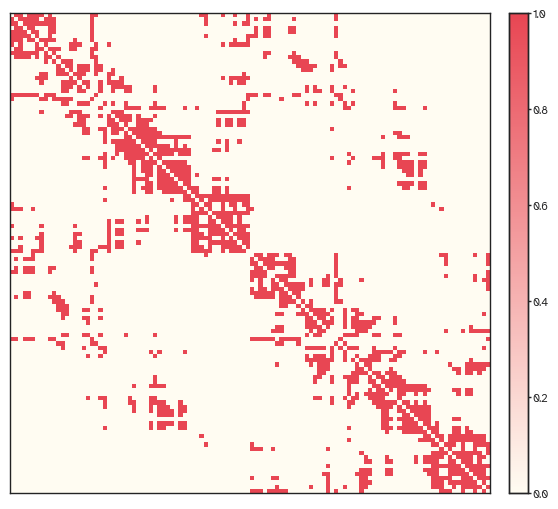

In [103]:
viz.plot_matrix(prediction,cbar=True,sns_kwargs=sns_kwargs)

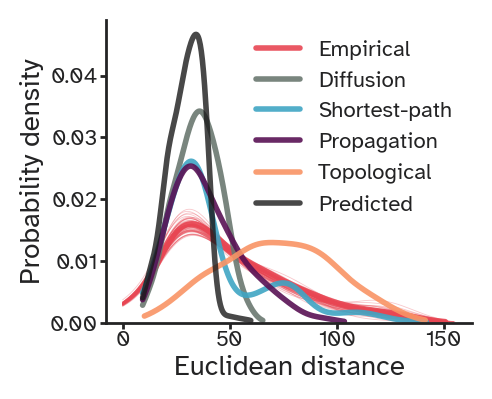

In [112]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=200)
cumu = False
sns.kdeplot(euclidean_dis[connectivity],
            label='Empirical',
            lw=2,
            alpha=0.9,
            color=viz_colors["warms"]["LECKER_RED"],
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)
for subject in range(all_connectivities.shape[2]):
    sns.kdeplot(euclidean_dis[all_connectivities[:,:,subject]],
                lw=0.3,
                alpha=0.3,
                color=viz_colors["warms"]["LECKER_RED"],
                fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)

sns.kdeplot(euclidean_dis[rd_samples[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Diffusion',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)


sns.kdeplot(euclidean_dis[best_sp[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Shortest-path',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu)
sns.kdeplot(euclidean_dis[best_pd[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Propagation',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu,
            color = viz_colors["purples"]["PURPLER"],)
sns.kdeplot(euclidean_dis[best_td[:,:,-1].astype(bool)],
            lw=2,
            alpha=0.9,
            label='Topological',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu,
            color = viz_colors["warms"]["ORANGE"],)

sns.kdeplot(euclidean_dis[prediction.astype(bool)],
            lw=2,
            alpha=0.8,
            label='Predicted',
            fill=False,bw_adjust=1.5,cut=0,cumulative=cumu,
            color = 'k',)

plt.xlabel('Euclidean distance')
plt.ylabel('Probability density')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
sns.despine()
plt.savefig("figures/res1_ed_kdeplot_with predictor.pdf",dpi=600,bbox_inches='tight');

In [408]:
evaluate_adjacency(rd_samples[:,:,5],prediction)

(90.90489381348107, 0.716546762589928)

# Gotta plot some brains here

# Playing with weighting schemes

In [156]:
from generative import optimize_weights

In [164]:
# Parameters
n_iterations = 100
alpha = 1.0  # Weight for distance term
beta = 0.01   # Weight for wiring cost
learning_rate = 0.01
total_weight = 1.0  # Each node has total weight of 1 to distribute

# Run optimization
weighted_history = optimize_weights(
    binary_adjacency=binary[:,:,-1],
    coordinates=coordinates,
    n_iterations=n_iterations,
    distance_fn=gen.resistance_distance,  # or your preferred distance metric
    alpha=alpha,
    beta=beta,
    total_weight=total_weight,
    learning_rate=learning_rate,
    n_jobs=-1,
)

Optimizing weights:   0%|          | 0/99 [00:00<?, ?it/s]

Optimizing weights: 100%|██████████| 99/99 [07:36<00:00,  4.61s/it]


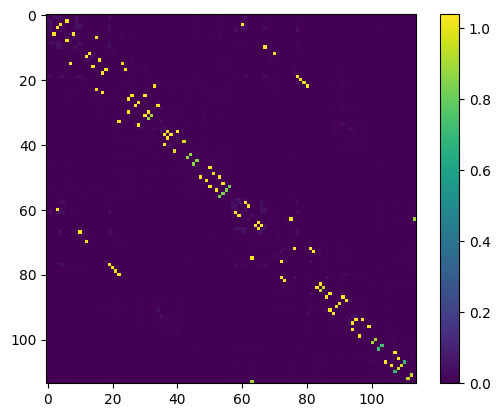

In [165]:
plt.imshow(weighted_history[:,:,-1])
plt.colorbar()

In [146]:
resdist = gen.resistance_distance(binary[:,:,-1], coordinates)
weighted = binary[:,:,-1]/euclidean_dis

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_1572/1299482811.py:2: RuntimeWarning: invalid value encountered in divide
  weighted = binary[:,:,-1]/euclidean_dis


In [149]:
empconn = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0]

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_1572/3289758425.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(empconn))


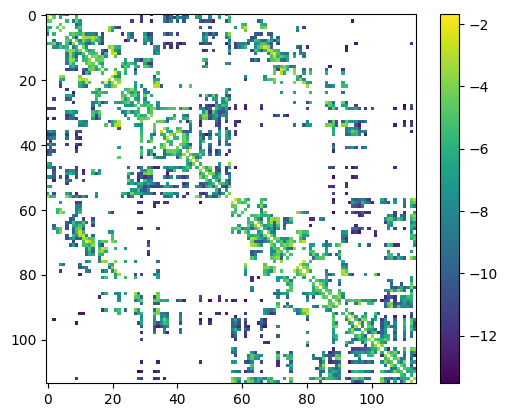

In [151]:
plt.imshow(np.log(empconn))
plt.colorbar()

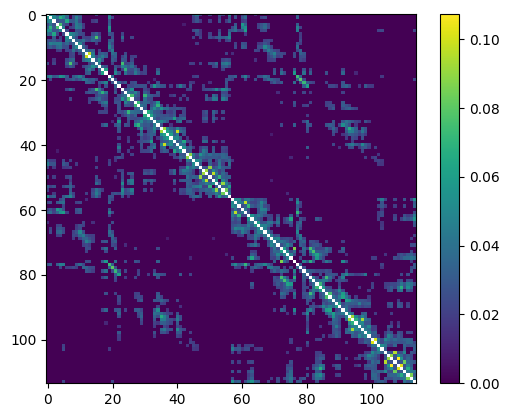

In [147]:
plt.imshow(weighted)
plt.colorbar()

<Axes: ylabel='Count'>

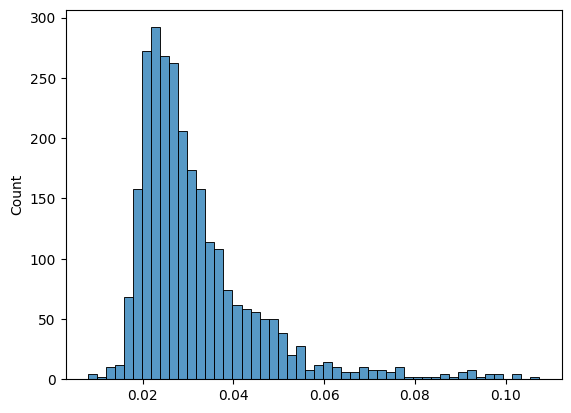

In [154]:
sns.histplot((weighted).ravel()[weighted.ravel()>0], bins=50)


In [32]:
# Vectorized correlation computation
flattened_history = history.reshape(history.shape[0] * history.shape[1], history.shape[2])
corr_matrix = np.corrcoef(flattened_history.T)


<Axes: >

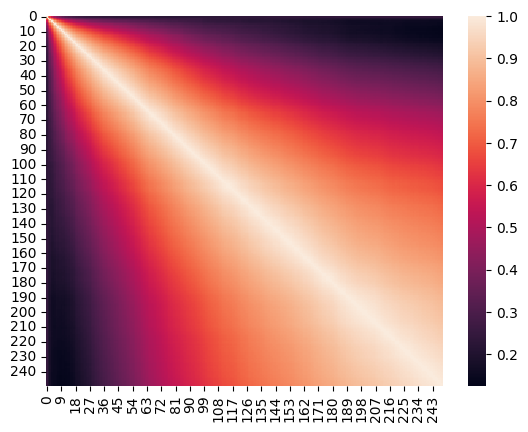

In [33]:
sns.heatmap(corr_matrix[::10,::10],vmin=corr_matrix.min(),vmax=1)

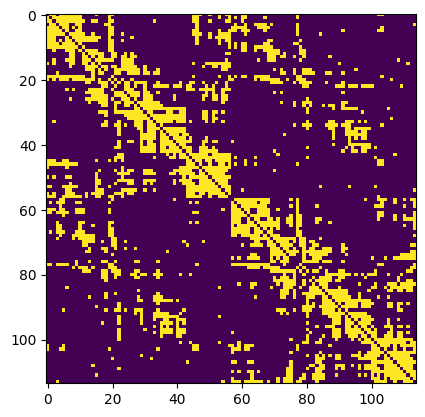

In [34]:
plt.imshow(history[:,:,-1])

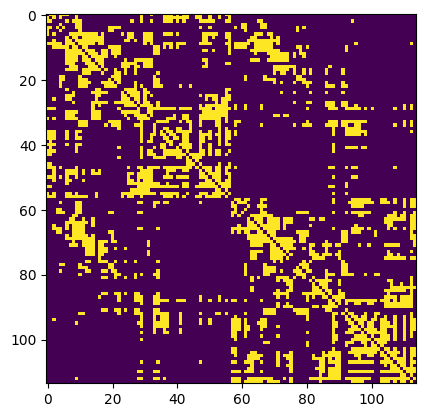

In [42]:
plt.imshow(connectivity)

In [35]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:38<00:00, 64.23it/s]


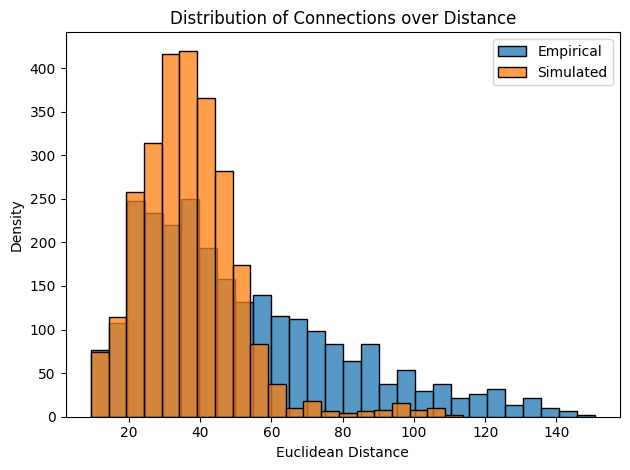

In [43]:
sns.histplot(euclidean_dis[connectivity],binwidth=5,label='Empirical')
what = history[:,:,-1].astype(bool)
sns.histplot(euclidean_dis[what],binwidth=5,label='Simulated')

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])